## generate adversary image 
This code is trying to generate adversary images based on MNIST classifier provided in Tensorflow Tutorial

### TensorFlow Tutorial  #1 (linear regression model)

import required libraries first

In [1]:
#import libraries
from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math
import pickle
%matplotlib inline

 load mnist dataset 

In [2]:
#load mnist dataset
mnist_data = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
#define number of classes and data size of each image
NUM_CLASSES = 10
IMAGE_SIZE_1D = 784  #28 * 28

define placeholders to put the input images and labels later

In [4]:
#define placeholders
x_data = tf.placeholder(tf.float32, shape=[None, IMAGE_SIZE_1D])
y_label = tf.placeholder(tf.float32, shape=[None, 10])

First, I try to train linear regression model and use it to generate adversary images of digit two.
Due to its linearity, the model should misclassify generated adverary image based on the added feature value.
For example, if I add feature value of digit six to the image of digit two, the model should predict the noise added images as digit six.

since logit is given by the following formula:  
$$ y = W^T X + b$$
gradint of loss respect to X would be W, which is weight parameter

In [5]:
#linear regression model
def linear_model(epochs, batch_size,epsilon,num_extract,adversary_dst_target,adversary_org_target):
    #follow TensorFlow turtorial
    #linear regression model
    
    #declare variables
    W = tf.Variable(tf.zeros([IMAGE_SIZE_1D,NUM_CLASSES]))
    b = tf.Variable(tf.zeros([NUM_CLASSES]))
    
     #setup loss function, gradient step, prediction, accuravy etc. 
    pred = tf.matmul(x_data,W) + b
    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_label, logits=pred))
    train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)
    correct_prediction = tf.equal(tf.argmax(pred,1), tf.argmax(y_label,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    #set flags to pick up images of digit two
    isDigitTwo = tf.equal(tf.argmax(pred,1), adversary_org_target)
    isCorrectTwo = tf.cast(tf.cast(correct_prediction,tf.float32) * tf.cast(isDigitTwo, tf.float32),tf.bool)
    isCorrectTwo_index = tf.where(isCorrectTwo)
    
    #np array to store generated imgs and extracted imgs
    generated_imgs = np.zeros((NUM_CLASSES,IMAGE_SIZE_1D))
    extracted_two_imgs = np.zeros((NUM_CLASSES,IMAGE_SIZE_1D))
    
    with tf.Session() as sess:
        #initialize variables
        sess.run(tf.global_variables_initializer())

        #train the model
        for _ in range(epochs):
            batch = mnist_data.train.next_batch(batch_size)
            train_step.run(feed_dict={x_data: batch[0], y_label: batch[1]})

        #evaluate the model by accuracy
        print("Accuracy is:", accuracy.eval(feed_dict={x_data: mnist_data.test.images, y_label: mnist_data.test.labels}))
        
        #extract 10 samples of digit two images
        pred_two = sess.run(isCorrectTwo_index, feed_dict={x_data:mnist_data.test.images,y_label: mnist_data.test.labels})
        index_two = [item for sublist in pred_two.tolist() for item in sublist]
        for j in range(num_extract):
            extracted_two_imgs[j] = mnist_data.test.images[index_two[j]]
        
        ### generate adversary images ###
        # gradient = gradient of WX + b respect to X -> gradient =  W
        # noise = epsilon * sign(gradient)
        W_var = sess.run(W)
        noise_six = epsilon * np.sign(W_var[:,adversary_dst_target])
        
        for i in range(num_extract):
            generated_imgs[i] = noise_six + extracted_two_imgs[i] 
            pred_w = sess.run(pred,feed_dict={x_data:np.reshape(generated_imgs[i],(1,IMAGE_SIZE_1D))})
            pred_w_index = np.argmax(pred_w)
            print ('prediction: %d' %pred_w_index)
        
        return generated_imgs,extracted_two_imgs;
        

In [6]:
#run the model
gen_imgs,org_imgs = linear_model(1000,100,0.25,10,6,2)

Accuracy is: 0.9184
prediction: 6
prediction: 6
prediction: 6
prediction: 6
prediction: 6
prediction: 6
prediction: 6
prediction: 6
prediction: 6
prediction: 6


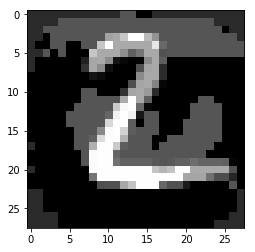

In [7]:
#visualize generated img
plt.imshow(np.reshape(gen_imgs[0],(28,28)), cmap='gray')

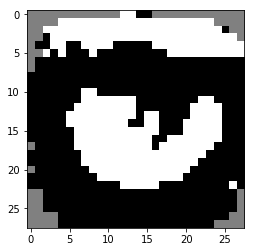

In [8]:
#visualize added weight
weight_added = gen_imgs - org_imgs
plt.imshow(np.reshape(weight_added[0],(28,28)),cmap='gray')

### TensorFlow Tutorial #2 (ConvNet)

In [9]:
#define batch size first
batch_siz = 50

In [10]:
#reshapre input data
x_image = tf.reshape(x_data, [-1, 28, 28, 1])

In [11]:
#define function to setup input variable
def input_img_variable(batch_size):
    return tf.Variable(tf.zeros([batch_size,28,28,1]),trainable=False)

In [12]:
#declare vraiable for img input
x_img_var = input_img_variable(batch_siz)

In [13]:
#assign openration for x_image
assign_x = tf.assign(x_img_var, x_image)

declare saver to save all parameter values after training

In [14]:
#functions for declare variables
def weight_variable(shape,name_):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial,name=name_)

def bias_variable(shape,name_):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial,name=name_)

#functions to define conv layer and pooling layes
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],strides=[1, 2, 2, 1], padding='SAME')

In [15]:
#define variables and tensors used for training here
#declare parameter values
W_conv1 = weight_variable([5, 5, 1, 32],"W_conv1")
b_conv1 = bias_variable([32],"b_conv1")
W_conv2 = weight_variable([5, 5, 32, 64],"W_conv2")
b_conv2 = bias_variable([64],"b_conv2")
W_fc1 = weight_variable([7 * 7 * 64, 1024],"W_fc1")
b_fc1 = bias_variable([1024],"b_fc1")
W_fc2 = weight_variable([1024, 10],"W_fc2")
b_fc2 = bias_variable([10],"b_fc2")

#first layer
h_conv1 = tf.nn.relu(conv2d(x_img_var, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

#second conv layer
h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

#flatten->fc layer->dropout
h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

#last layer
y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

#define loss func, gradient step, prediction
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_label, logits=y_conv))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy,var_list=[W_conv1, b_conv1,W_conv2,b_conv2,W_fc1,b_fc1,W_fc2,b_fc2])
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_label, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

#define saver to save the trained parameters later
saver = tf.train.Saver(tf.global_variables())


In [16]:
def convnet_model_train(epochs,batch_size):
    #convnet model
    
    #calculate batch size for testing dataset
    iteration_num = math.ceil(mnist_data.test.labels.shape[0] / batch_size)
    accu_total = 0
    accu_mean = 0

    #train, evaluate
    with tf.Session() as sess:
        #initialize parameters
        sess.run(tf.global_variables_initializer())
    
        #train for given epoch times
        for i in range(epochs): #20000
            batch = mnist_data.train.next_batch(batch_size) #50
            sess.run(assign_x, feed_dict={x_data:batch[0]})
            if i % 100 == 0:
                train_accuracy = accuracy.eval(feed_dict={y_label: batch[1], keep_prob: 1.0})
                print('step %d, training accuracy %g' % (i, train_accuracy))
            train_step.run(feed_dict={y_label: batch[1], keep_prob: 0.5})

        #evaluate the accuracy of the model by using test set
        for k in range(iteration_num):
            batch_test = mnist_data.test.next_batch(batch_size)
            sess.run(assign_x,feed_dict={x_data:batch_test[0]})
            accu_total += accuracy.eval(feed_dict={y_label: batch_test[1], keep_prob: 1.0})
        accu_mean = accu_total / iteration_num
        print('average test accuracy %.4f' %accu_mean )

        #save the current parameter values
        save_path = saver.save(sess,"./MNIST_weight/model_weight.ckpt")
        print('weight saved to %s' %save_path)


In [17]:
#train the model
convnet_model_train(1000,50)

step 0, training accuracy 0.18
step 100, training accuracy 0.8
step 200, training accuracy 0.92
step 300, training accuracy 0.96
step 400, training accuracy 0.9
step 500, training accuracy 0.98
step 600, training accuracy 0.94
step 700, training accuracy 0.94
step 800, training accuracy 0.96
step 900, training accuracy 0.94
average test accuracy 0.9618
weight saved to ./MNIST_weight/model_weight.ckpt


### try to generate adversary images

try to generate adversary images by adding some noise to extracted image of digit 2. 
On writing this part, this link was really useful. [PASTE LINK LATER]

first, try to visualize extracted imgs

In [20]:
#extract the images of digit two
def convnet_model_extract(batch_size,adversary_org_target):
    #define flags etc. to extract digit 2 images
    isDigitTwo = tf.equal(tf.argmax(y_label,1), adversary_org_target)
    isCorrectTwo = tf.cast(tf.cast(correct_prediction,tf.float32) * tf.cast(isDigitTwo, tf.float32),tf.bool)
    isCorrectTwo_index = tf.where(isCorrectTwo)

    #declare list to store extracted images and counter
    extracted_two_imgs = np.zeros((batch_size,IMAGE_SIZE_1D))
    count = 0

    #calculate batch size for testing dataset
    iteration_num = math.ceil(mnist_data.test.labels.shape[0] / batch_size)
    accu_total = 0
    accu_mean = 0

    ### extract the img data
    with tf.Session() as sess:
        #initialize all variables
        sess.run(tf.global_variables_initializer())

        #restore parameter valuers
        saver.restore(sess,"./MNIST_weight/model_weight.ckpt")
        print('model is restored')

        #make sure the model is resotred properly
        for k in range(iteration_num):
            batch_test = mnist_data.test.next_batch(batch_size)
            sess.run(assign_x,feed_dict={x_data:batch_test[0]})
            accu_total += accuracy.eval(feed_dict={y_label: batch_test[1], keep_prob: 1.0})
        accu_mean = accu_total / iteration_num
        print('average test accuracy %.4f' %accu_mean )

        #iterate test data set
        for i in range(iteration_num):
            batch_test = mnist_data.test.next_batch(batch_size)
            sess.run(assign_x,feed_dict={x_data:batch_test[0]})

            #extract digit two
            i = 0
            pred_two = sess.run(isCorrectTwo_index, feed_dict={y_label: batch_test[1], keep_prob:1.0})
            index_two = [item for sublist in pred_two.tolist() for item in sublist]
            while( batch_size > count and i < len(index_two)):
                extracted_two_imgs[count] = batch_test[0][index_two[i]]
                i += 1
                count += 1

        #pickle extracted imgs
        with open('./mnist_extract_imgs.p','wb') as f:
            pickle.dump([extracted_two_imgs],f)
        print('extracted images pickled')
            
    return extracted_two_imgs

In [21]:
#extract the imgs
extracted_two_imgs = convnet_model_extract(batch_siz,2)

INFO:tensorflow:Restoring parameters from ./MNIST_weight/model_weight.ckpt
model is restored
average test accuracy 0.9618
extracted images pickled


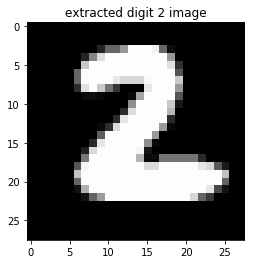

In [29]:
#visualize one of the samples in extracted_two_imgs
data = extracted_two_imgs[1]
plt.imshow(np.reshape(data,(28,28)),cmap='gray')
plt.title("extracted digit 2 image")

re-define parameters as untrainable and also define noise images as variable

generate new images by using the model weights

In [25]:
def convnet_model_adversary_six(epochs,batch_size,input_imgs):
    #generate new image 
    #retrieve variables 
    with open('./mnist_extract_imgs.p','rb') as f:
        extracted_two_imgs = pickle.load(f)

    #define correct class and make it one-hot code
    class_two = [2]
    onehot_two = np.eye(NUM_CLASSES)[class_two]
    class_six = [6]
    onehot_six = np.eye(NUM_CLASSES)[class_six]
    onehot_six_mult = np.zeros((batch_size,NUM_CLASSES))
    onehot_two_mult = np.zeros((batch_size,NUM_CLASSES))
    for i in range(batch_size):
        onehot_six_mult[i] = onehot_six
        onehot_two_mult[i] = onehot_two

    #define another optimizer to update input image
    opt = tf.train.GradientDescentOptimizer(learning_rate=0.2).minimize(cross_entropy,var_list=[x_img_var])

    #np array to store generated img
    gen_imgs = input_imgs

    #calculate batch size for testing dataset
    iteration_num = math.ceil(mnist_data.test.labels.shape[0] / batch_size)
    accu_total = 0
    accu_mean = 0

    ### generate
    with tf.Session() as sess:
         #initialize all variables
        sess.run(tf.global_variables_initializer())

        #restore parameter valuers
        saver.restore(sess,"./MNIST_weight/model_weight.ckpt")
        print('model is restored')

        #for each image in extracted two, get gradient
        for i in range(epochs): #110
            #the formula for added noise is:
            # n = epcilon * sign(gradient of loss respect to x)
            sess.run(assign_x, feed_dict={x_data:np.reshape(gen_imgs,(batch_size,IMAGE_SIZE_1D))})
            opt.run(feed_dict={y_label: onehot_six_mult, keep_prob: 0.5})
            gen_imgs = sess.run(x_img_var)

            if((i+1) % 10 == 0):
                diff = np.reshape(gen_imgs,(batch_size,IMAGE_SIZE_1D)) - np.reshape(extracted_two_imgs,(batch_size,IMAGE_SIZE_1D))
                diff_sum = np.sum(np.sum(diff))
                print ('step%d: %.7f'%((i+1),diff_sum))

        #error rate of classifying those images as six
        sess.run(assign_x,feed_dict={x_data:np.reshape(gen_imgs,(batch_size,IMAGE_SIZE_1D))})
        accu = accuracy.eval(feed_dict={y_label: onehot_six_mult, keep_prob: 1.0})
        print ('error rate to classify the images as six is: %.4f' %accu)
    
        #check that to which catrgoly the added noise classified
        n = np.reshape(gen_imgs,(batch_size,IMAGE_SIZE_1D)) - np.reshape(extracted_two_imgs,(batch_size,IMAGE_SIZE_1D))
        sess.run(assign_x,feed_dict={x_data:np.reshape(n,(batch_size,IMAGE_SIZE_1D))})
        pred_noise = sess.run(y_conv,feed_dict={keep_prob:1.0})
        pred_noise_list = np.argmax(pred_noise,axis=1).tolist()
        for i in range(batch_size):
            print('prediction of noise%d: %d' %(i,pred_noise_list[i]))
    
        #make sure the model parameters are not updated
        for k in range(iteration_num):
            batch_test = mnist_data.test.next_batch(batch_size)
            sess.run(assign_x,feed_dict={x_data:batch_test[0]})
            accu_total += accuracy.eval(feed_dict={y_label: batch_test[1], keep_prob: 1.0})
        accu_mean = accu_total / iteration_num
        print('average test accuracy %.4f' %accu_mean )

        #reshape the generated imgs 
        np.reshape(n,(batch_size,IMAGE_SIZE_1D))
        np.reshape(gen_imgs,(batch_size,IMAGE_SIZE_1D))

        return n,gen_imgs

In [26]:
#generarte adversary images
added_noise,generated_imgs = convnet_model_adversary_six(110,batch_siz,extracted_two_imgs)

INFO:tensorflow:Restoring parameters from ./MNIST_weight/model_weight.ckpt
model is restored
step10: 28.8635332
step20: 56.6058042
step30: 81.1396610
step40: 101.4012705
step50: 118.2494335
step60: 133.0972746
step70: 144.4568230
step80: 153.1711919
step90: 160.1786965
step100: 165.5825876
step110: 170.4527981
error rate to classify the images as six is: 0.9800
prediction of noise0: 1
prediction of noise1: 1
prediction of noise2: 1
prediction of noise3: 7
prediction of noise4: 1
prediction of noise5: 1
prediction of noise6: 1
prediction of noise7: 1
prediction of noise8: 1
prediction of noise9: 1
prediction of noise10: 1
prediction of noise11: 1
prediction of noise12: 1
prediction of noise13: 1
prediction of noise14: 1
prediction of noise15: 1
prediction of noise16: 1
prediction of noise17: 1
prediction of noise18: 1
prediction of noise19: 1
prediction of noise20: 1
prediction of noise21: 1
prediction of noise22: 1
prediction of noise23: 1
prediction of noise24: 1
prediction of noise25

visualize noise images added

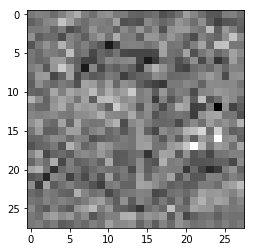

In [30]:
plt.imshow(np.reshape(added_noise[1],(28,28)),cmap='gray')

visualize generated img

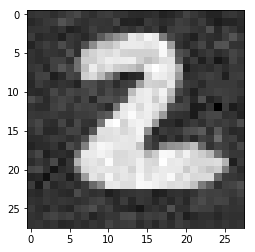

In [31]:
plt.imshow(np.reshape(generated_imgs[1],(28,28)),cmap='gray')

In [ ]:
#compare original img, added noise and generated images
